In [45]:
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn import tree
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn import neighbors
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

In [2]:
df_train = pd.read_csv("titanic_train.csv") 
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
def clean_data(df, drop_passenger_id):
    
    # Get the unique values of Sex
    sexes = sorted(df['Sex'].unique())
    
    # Generate a mapping of Sex from a string to a number representation    
    genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))

    # Transform Sex from a string to a number representation
    df['Sex_Val'] = df['Sex'].map(genders_mapping).astype(int)
    
    # Get the unique values of Embarked
    embarked_locs = sorted(df['Embarked'].fillna('S').unique())

    # Generate a mapping of Embarked from a string to a number representation        
    embarked_locs_mapping = dict(zip(embarked_locs, 
                                     range(0, len(embarked_locs) + 1)))
    
    # Transform Embarked from a string to dummy variables
    df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked_Val')], axis=1)
    
    # Fill in missing values of Embarked
    # Since the vast majority of passengers embarked in 'S': 3, 
    # we assign the missing values in Embarked to 'S':
#     if len(df[df['Embarked'].isnull()] > 0):
#         df.replace({'Embarked_Val' : 
#                        { embarked_locs_mapping[np.nan] : embarked_locs_mapping['S'] 
#                        }
#                    }, 
#                    inplace=True)
    
#     Fill in missing values of Fare with the average Fare
#     if len(df[df['Fare'].isnull()] > 0):
#         avg_fare = df['Fare'].mean()
#         df.replace({ None: avg_fare }, inplace=True)
    
    df['Fare'].fillna(df['Fare'].mean())
    
    # To keep Age intact, make a copy of it called AgeFill 
    # that we will use to fill in the missing ages:
    df['AgeFill'] = df['Age']

    # Determine the Age typical for each passenger class by Sex_Val.  
    # We'll use the median instead of the mean because the Age 
    # histogram seems to be right skewed.
    df['AgeFill'] = df['AgeFill'] \
                        .groupby([df['Sex_Val'], df['Pclass']]) \
                        .apply(lambda x: x.fillna(x.median()))
            
    # Define a new feature FamilySize that is the sum of 
    # Parch (number of parents or children on board) and 
    # SibSp (number of siblings or spouses):
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    # Drop the columns we won't use:
    df = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
    
    # Drop the Age column since we will be using the AgeFill column instead.
    # Drop the SibSp and Parch columns since we will be using FamilySize.
    # Drop the PassengerId column since it won't be used as a feature.
    df = df.drop(['Age', 'SibSp', 'Parch'], axis=1)
    
    if drop_passenger_id:
        df = df.drop(['PassengerId'], axis=1)
    
    return df

In [4]:
df_train.dtypes[df_train.dtypes.map(lambda x: x == 'object')]

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

In [5]:
df_train = clean_data(df_train, drop_passenger_id=True)
df_train.head()

,Survived,Pclass,Fare,Sex_Val,Embarked_Val_C,Embarked_Val_Q,Embarked_Val_S,AgeFill,FamilySize
0,0,3,7.2500,1,0,0,1,22.0,1
1,1,1,71.2833,0,1,0,0,38.0,1
2,1,3,7.9250,0,0,0,1,26.0,0
3,1,1,53.1000,0,0,0,1,35.0,1
4,0,3,8.0500,1,0,0,1,35.0,0


In [6]:
df_train.dtypes

Survived            int64
Pclass              int64
Fare              float64
Sex_Val             int64
Embarked_Val_C      uint8
Embarked_Val_Q      uint8
Embarked_Val_S      uint8
AgeFill           float64
FamilySize          int64
dtype: object

In [7]:
#Convert the DataFrame to a numpy array:
train_data = df_train.values
train_data

array([[  0.    ,   3.    ,   7.25  , ...,   1.    ,  22.    ,   1.    ],
       [  1.    ,   1.    ,  71.2833, ...,   0.    ,  38.    ,   1.    ],
       [  1.    ,   3.    ,   7.925 , ...,   1.    ,  26.    ,   0.    ],
       ..., 
       [  0.    ,   3.    ,  23.45  , ...,   1.    ,  21.5   ,   3.    ],
       [  1.    ,   1.    ,  30.    , ...,   0.    ,  26.    ,   0.    ],
       [  0.    ,   3.    ,   7.75  , ...,   0.    ,  32.    ,   0.    ]])

In [10]:
# Training data features, skip the first column 'Survived'
train_features = train_data[:, 1:]
train_features[:5]

array([[  3.    ,   7.25  ,   1.    ,   0.    ,   0.    ,   1.    ,
         22.    ,   1.    ],
       [  1.    ,  71.2833,   0.    ,   1.    ,   0.    ,   0.    ,
         38.    ,   1.    ],
       [  3.    ,   7.925 ,   0.    ,   0.    ,   0.    ,   1.    ,
         26.    ,   0.    ],
       [  1.    ,  53.1   ,   0.    ,   0.    ,   0.    ,   1.    ,
         35.    ,   1.    ],
       [  3.    ,   8.05  ,   1.    ,   0.    ,   0.    ,   1.    ,
         35.    ,   0.    ]])

In [11]:
# 'Survived' column values
train_target = train_data[:, 0]
train_target[:5]

array([ 0.,  1.,  1.,  1.,  0.])

In [19]:
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                  min_samples_split=2, min_samples_leaf=2)
clf = clf.fit(train_features, train_target)

In [20]:
clf.feature_importances_

array([ 0.12576359,  0.22503278,  0.36606909,  0.00671932,  0.00309573,
        0.00425868,  0.20762893,  0.06143187])

In [22]:
pred_target = clf.predict(train_features)

print(metrics.precision_score(train_target, pred_target, average='weighted'))
print(metrics.recall_score(train_target, pred_target, average='weighted'))
print(metrics.f1_score(train_target, pred_target, average='weighted'))
print(metrics.accuracy_score(train_target, pred_target))
print(metrics.precision_recall_fscore_support(train_target, pred_target))

0.92279265775
0.919191919192
0.917765238532
0.919191919192
(array([ 0.89816361,  0.96232877]), array([ 0.97996357,  0.82163743]), array([ 0.93728223,  0.88643533]), array([549, 342]))


In [23]:
len(train_data)

891

In [24]:
train_x, test_x, train_y, test_y = train_test_split(train_features, 
                                                    train_target, 
                                                    test_size=0.20, 
                                                    random_state=0)

In [25]:
train_x.shape, test_x.shape

((712, 8), (179, 8))

In [26]:
len(train_x), len(test_x), len(train_x) + len(test_x)

(712, 179, 891)

In [27]:
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3, 
                                  min_samples_split=2, min_samples_leaf=10)
clf = clf.fit(train_x, train_y)

In [28]:
train_pred = clf.predict(train_x)
test_pred = clf.predict(test_x)

In [29]:
print(metrics.accuracy_score(train_y, train_pred))
print(metrics.accuracy_score(test_y, test_pred))

0.832865168539
0.826815642458


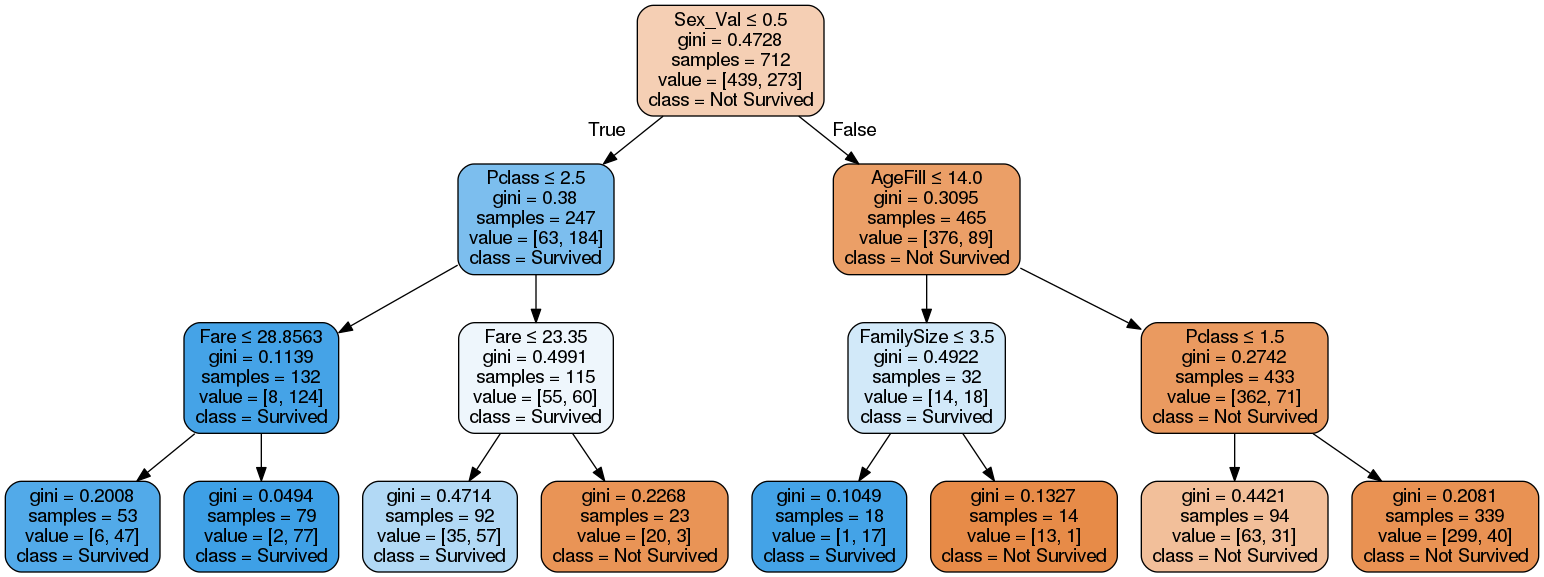

In [32]:
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=list(df_train.columns[1:]),  
                         class_names=['Not Survived', 'Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [33]:
cm = confusion_matrix(test_y, test_pred)
print(cm)

[[96 14]
 [17 52]]


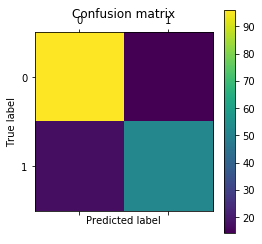

In [34]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [35]:
from sklearn.metrics import classification_report
print(classification_report(test_y, 
                            test_pred, 
                            target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.85      0.87      0.86       110
    Survived       0.79      0.75      0.77        69

 avg / total       0.83      0.83      0.83       179



In [43]:
# cross validation
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.81 (+/- 0.05)


In [44]:
cross_validation.cross_val_score??

In [47]:
# Do not use deprecated modules
scores = cross_val_score(clf, train_features, train_target, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.81 (+/- 0.05)


In [49]:
# Random Forest

clf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=None,
                             max_depth=None, 
                             min_samples_split=2,
                             min_samples_leaf=5,
                             bootstrap=True,
                             oob_score=False,
                             random_state=None,
                             class_weight=None) #balanced
scores = cross_val_score(clf, train_features, train_target, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.08)


In [50]:
RandomForestClassifier??

In [51]:
clf.base_estimator

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [53]:
lf = neighbors.KNeighborsClassifier(10, weights='distance')
scores = cross_validation.cross_val_score(lf, train_features, train_target, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.73 (+/- 0.06)


In [54]:
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [55]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [56]:
np.flatnonzero??

In [57]:
clf = RandomForestClassifier(n_estimators=20)

In [58]:
param_dist = {"max_depth": [2,3,4,5,6,7,8,9,10,11,12,None],
              "max_features": sp_randint(1, len(train_x[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}

n_iter_search = 100
search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, 
                            n_jobs=10, scoring=make_scorer(accuracy_score))

In [70]:
RandomizedSearchCV??

In [64]:
search.fit(train_features, train_target)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=10,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d581dc908>, 'bootstrap': [True], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d581dc898>, 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, None], 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d581dc048>, 'criterion': ['entropy', 'gini'], 'class_weight': ['balanced', None, {0: 0.3, 1: 0.7}]},
          pre_disp

In [65]:
report(search.cv_results_, 3) #search.best_estimator_.estimators_[0]

Model with rank: 1
Mean validation score: 0.820 (std: 0.029)
Parameters: {'max_features': 8, 'bootstrap': True, 'min_samples_split': 12, 'max_depth': 9, 'min_samples_leaf': 10, 'criterion': 'gini', 'class_weight': None}

Model with rank: 2
Mean validation score: 0.811 (std: 0.010)
Parameters: {'max_features': 5, 'bootstrap': True, 'min_samples_split': 48, 'max_depth': 6, 'min_samples_leaf': 11, 'criterion': 'entropy', 'class_weight': None}

Model with rank: 3
Mean validation score: 0.806 (std: 0.019)
Parameters: {'max_features': 5, 'bootstrap': True, 'min_samples_split': 24, 'max_depth': 8, 'min_samples_leaf': 14, 'criterion': 'entropy', 'class_weight': 'balanced'}



In [73]:
search.best_estimator_.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=12,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=205536571, splitter='best')

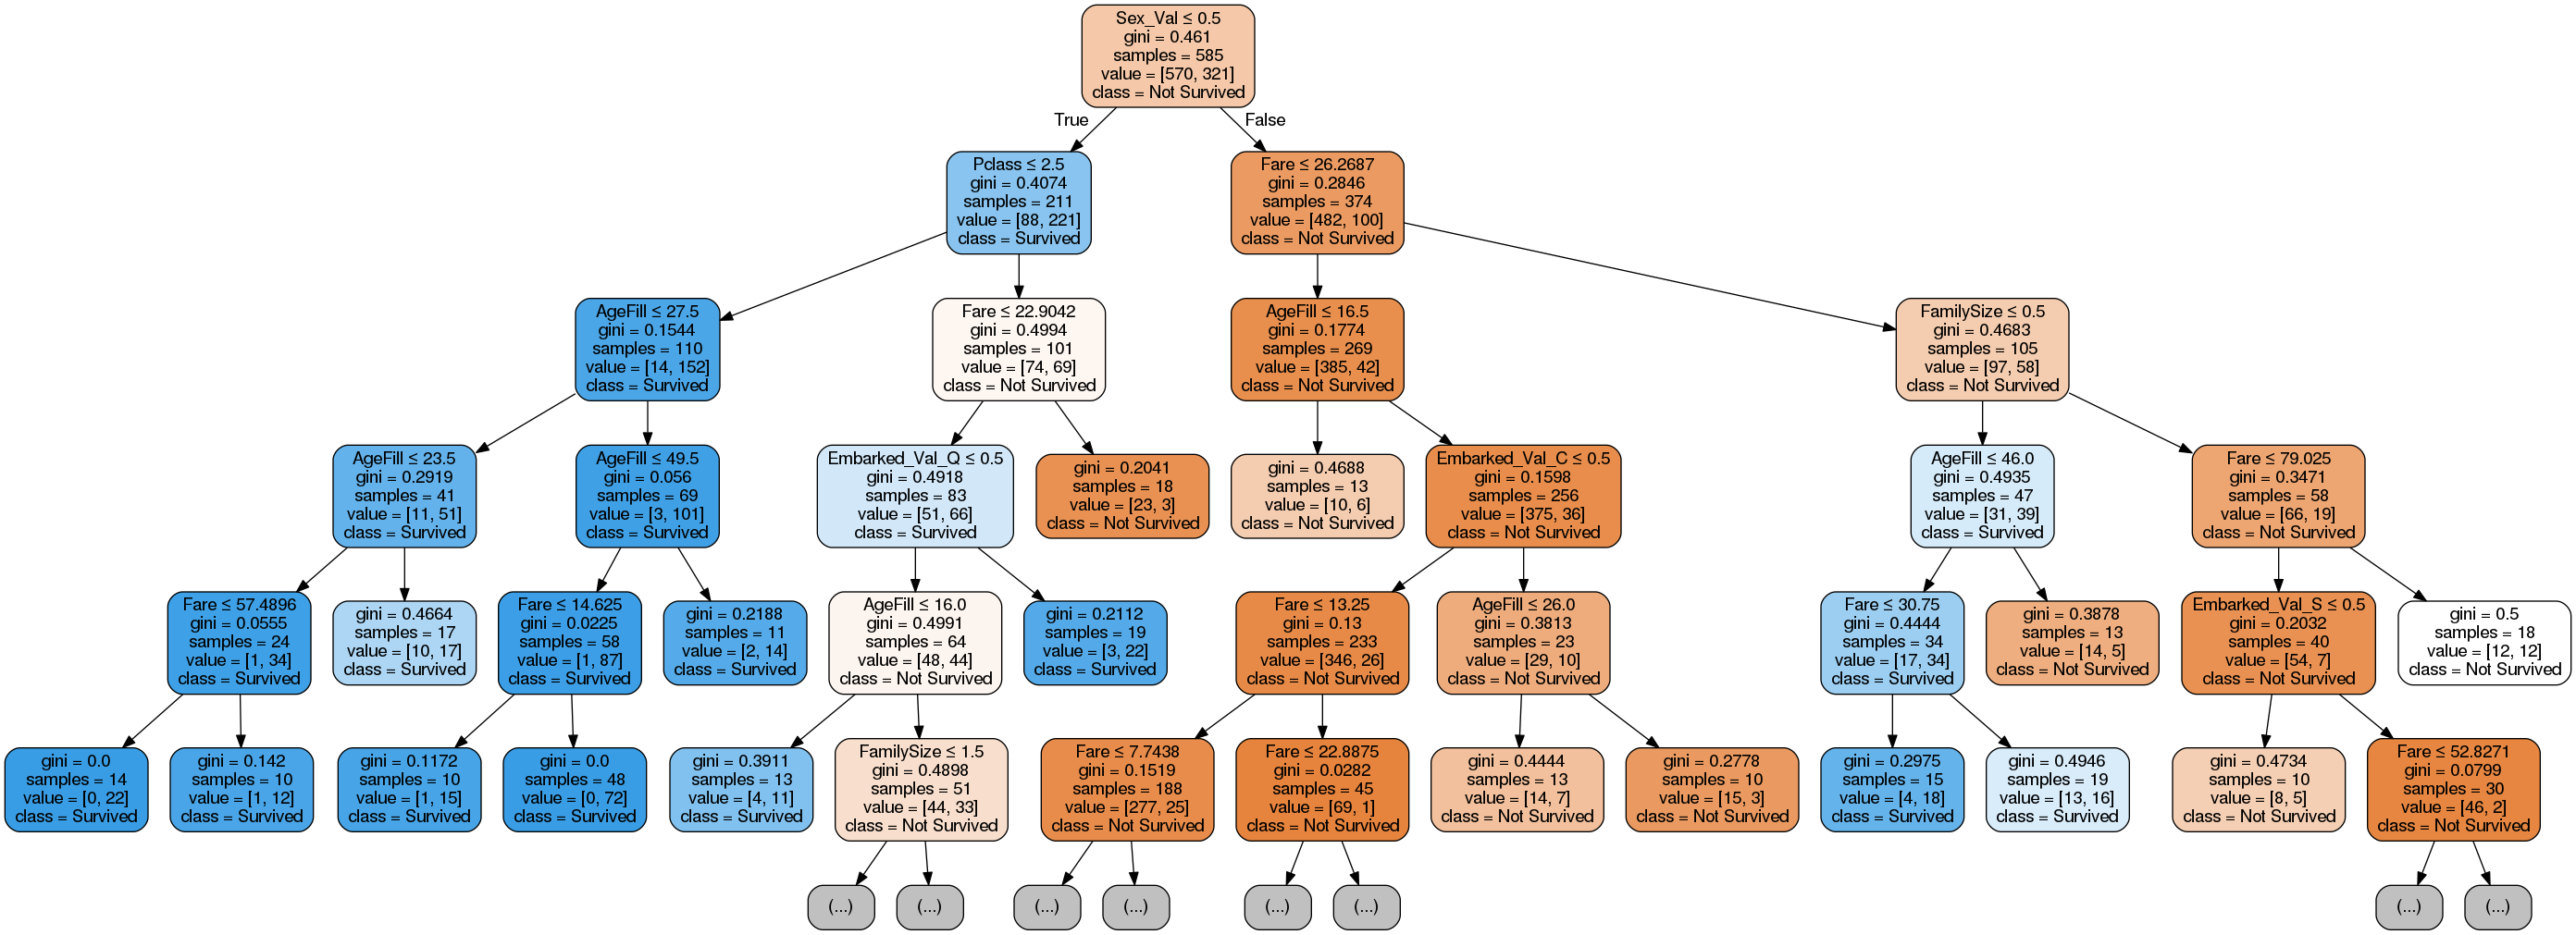

In [74]:
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(search.best_estimator_.estimators_[0], out_file=None, 
                         feature_names=list(df_train.columns[1:]),  
                         class_names=['Not Survived', 'Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True,
                               max_depth=5)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [75]:
#
# k-NN
#
from sklearn import neighbors
import numpy as np

In [76]:
n_neighbors = 3
weights = 'uniform'
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [77]:
clf.fit(train_features, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [79]:
for i in range(10):
    p = clf.predict(train_features[i].reshape(1, -1))
    print(i, ":", train_features[i], "predicted: ", p[0], " real: ", train_target[i])

0 : [  3.     7.25   1.     0.     0.     1.    22.     1.  ] predicted:  0.0  real:  0.0
1 : [  1.      71.2833   0.       1.       0.       0.      38.       1.    ] predicted:  1.0  real:  1.0
2 : [  3.      7.925   0.      0.      0.      1.     26.      0.   ] predicted:  1.0  real:  1.0
3 : [  1.   53.1   0.    0.    0.    1.   35.    1. ] predicted:  1.0  real:  1.0
4 : [  3.     8.05   1.     0.     0.     1.    35.     0.  ] predicted:  0.0  real:  0.0
5 : [  3.       8.4583   1.       0.       1.       0.      25.       0.    ] predicted:  0.0  real:  0.0
6 : [  1.      51.8625   1.       0.       0.       1.      54.       0.    ] predicted:  0.0  real:  0.0
7 : [  3.     21.075   1.      0.      0.      1.      2.      4.   ] predicted:  0.0  real:  0.0
8 : [  3.      11.1333   0.       0.       0.       1.      27.       2.    ] predicted:  1.0  real:  1.0
9 : [  2.      30.0708   0.       1.       0.       0.      14.       1.    ] predicted:  1.0  real:  1.0


In [80]:
print("error: ", sum(abs(np.array(clf.predict(train_features)) - np.array(train_target))))

error:  139.0


In [81]:
train_features_norm = (train_features - train_features.mean(axis=0))/ train_features.std(axis=0)

In [82]:
clf.fit(train_features_norm, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [84]:
for i in range(10):
    p = clf.predict(train_features_norm[i].reshape(1, -1))
    print(i, ":", train_features_norm[i], "predicted: ", p[0], " real: ", train_target[i])

0 : [ 0.82737724 -0.50244517  0.73769513 -0.48204268 -0.30756234  0.61930636
 -0.53489116  0.05915988] predicted:  0.0  real:  0.0
1 : [-1.56610693  0.78684529 -1.35557354  2.0745051  -0.30756234 -1.61470971
  0.66839176  0.05915988] predicted:  1.0  real:  1.0
2 : [ 0.82737724 -0.48885426 -1.35557354 -0.48204268 -0.30756234  0.61930636
 -0.23407043 -0.56097483] predicted:  1.0  real:  1.0
3 : [-1.56610693  0.42073024 -1.35557354 -0.48204268 -0.30756234  0.61930636
  0.44277621  0.05915988] predicted:  1.0  real:  1.0
4 : [ 0.82737724 -0.48633742  0.73769513 -0.48204268 -0.30756234  0.61930636
  0.44277621 -0.56097483] predicted:  0.0  real:  0.0
5 : [ 0.82737724 -0.47811643  0.73769513 -0.48204268  3.25137334 -1.61470971
 -0.30927562 -0.56097483] predicted:  0.0  real:  0.0
6 : [-1.56610693  0.39581356  0.73769513 -0.48204268 -0.30756234  0.61930636
  1.87167468 -0.56097483] predicted:  0.0  real:  0.0
7 : [ 0.82737724 -0.22408312  0.73769513 -0.48204268 -0.30756234  0.61930636
 -2.03

In [87]:
print("error: ", sum(abs(np.array(clf.predict(train_features_norm)) \
                         - np.array(train_target))))

error:  113.0


In [88]:
#
# Naive Bayes
#
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Gaussian NB, for normally distributed numerical values  --> more generally applicable
gnb = GaussianNB()
gnb.fit(train_features, train_target)

# Multinomial NB, for discrete labels (yet still numerical)
three_discrete_vars = train_features[:,[0,2,3]]
mnb = MultinomialNB()
mnb.fit(three_discrete_vars, train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [89]:
for i in range(10):
    p = gnb.predict(train_features[i].reshape(1, -1))
    print(i, ":", train_features[i], "predicted: ", p[0], " real: ", train_target[i])
print("error: ", sum(abs(np.array(gnb.predict(train_features)) \
                         - np.array(train_target))))

0 : [  3.     7.25   1.     0.     0.     1.    22.     1.  ] predicted:  0.0  real:  0.0
1 : [  1.      71.2833   0.       1.       0.       0.      38.       1.    ] predicted:  1.0  real:  1.0
2 : [  3.      7.925   0.      0.      0.      1.     26.      0.   ] predicted:  0.0  real:  1.0
3 : [  1.   53.1   0.    0.    0.    1.   35.    1. ] predicted:  1.0  real:  1.0
4 : [  3.     8.05   1.     0.     0.     1.    35.     0.  ] predicted:  0.0  real:  0.0
5 : [  3.       8.4583   1.       0.       1.       0.      25.       0.    ] predicted:  0.0  real:  0.0
6 : [  1.      51.8625   1.       0.       0.       1.      54.       0.    ] predicted:  0.0  real:  0.0
7 : [  3.     21.075   1.      0.      0.      1.      2.      4.   ] predicted:  0.0  real:  0.0
8 : [  3.      11.1333   0.       0.       0.       1.      27.       2.    ] predicted:  0.0  real:  1.0
9 : [  2.      30.0708   0.       1.       0.       0.      14.       1.    ] predicted:  1.0  real:  1.0
error:  183.

In [90]:
for i in range(10):
    p = mnb.predict(three_discrete_vars[i].reshape(1, -1))
    print(i, ":", three_discrete_vars[i], "predicted: ", p[0], " real: ", train_target[i])
print("error: ", sum(abs(np.array(mnb.predict(three_discrete_vars)) \
                         - np.array(train_target))))

0 : [ 3.  1.  0.] predicted:  0.0  real:  0.0
1 : [ 1.  0.  1.] predicted:  1.0  real:  1.0
2 : [ 3.  0.  0.] predicted:  0.0  real:  1.0
3 : [ 1.  0.  0.] predicted:  0.0  real:  1.0
4 : [ 3.  1.  0.] predicted:  0.0  real:  0.0
5 : [ 3.  1.  0.] predicted:  0.0  real:  0.0
6 : [ 1.  1.  0.] predicted:  0.0  real:  0.0
7 : [ 3.  1.  0.] predicted:  0.0  real:  0.0
8 : [ 3.  0.  0.] predicted:  0.0  real:  1.0
9 : [ 2.  0.  1.] predicted:  1.0  real:  1.0
error:  316.0


In [91]:
#
# Neural Networks
#
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(train_features, train_target)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [92]:
MLPClassifier??

In [94]:
print("error: ", sum(abs(np.array(clf.predict(train_features)) \
                         - np.array(train_target))))

error:  231.0


In [95]:
# weights of the network
clf.coefs_

[array([[ -0.11273561,   0.29933739,  -6.60650497,  -0.26470224,
          -1.05402645],
        [ -0.55385717,  -0.42625333,  -0.51823925,  -0.13169746,
          -0.02460837],
        [ -0.109784  ,   0.25164302,  13.69826063,   0.51421074,
          -1.02176823],
        [  0.23160067,  -0.1123514 ,  -9.1598139 ,  -0.48814521,
          -0.14129491],
        [  0.40859776,   0.63618981,  -0.08253135,   0.26214523,
           0.63871265],
        [  0.53612073,  -0.56376747,   2.11746928,  -0.44857519,
           0.11627445],
        [ -0.54569426,  -0.1071848 ,   1.24801883,   0.07274628,
           0.16706559],
        [ -0.25064426,   0.253384  ,   4.70991413,  -0.65446346,
          -0.33433067]]), array([[-0.0964745 ,  0.75650957],
        [-0.38212088, -0.39293136],
        [-0.68499757, -1.23290516],
        [ 0.3311118 , -0.53279336],
        [-0.43408749,  1.31826133]]), array([[-0.99912022],
        [ 2.70277518]])]

In [98]:
#
# Support Vector Machines
#
from sklearn import svm
clf = svm.SVC()
clf.fit(train_features, train_target)
print("error: ", sum(abs(np.array(clf.predict(train_features)) \
                         - np.array(train_target))))

error:  93.0


In [99]:
# Fit the model to our training data
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                  min_samples_split=2, min_samples_leaf=2)
clf = clf.fit(train_x, train_y)
y_score = clf.predict_proba(test_x)
y_pred = clf.predict(test_x)

In [100]:
tree.DecisionTreeClassifier??

In [101]:
tree.DecisionTreeClassifier.predict_proba??

In [102]:
for i in range(10):
    print(y_score[i], y_pred[i], test_y[i], 'Yes' if y_pred[i] == test_y[i] else 'No')

[ 1.  0.] 0.0 0.0 Yes
[ 1.  0.] 0.0 0.0 Yes
[ 1.  0.] 0.0 0.0 Yes
[ 0.  1.] 1.0 1.0 Yes
[ 0.66666667  0.33333333] 0.0 1.0 No
[ 0.5  0.5] 0.0 1.0 No
[ 0.  1.] 1.0 1.0 Yes
[ 0.  1.] 1.0 1.0 Yes
[ 0.  1.] 1.0 1.0 Yes
[ 0.  1.] 1.0 1.0 Yes


In [103]:
# Get a less complex tree
clf2 = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                  min_samples_split=2, min_samples_leaf=10)
clf2 = clf2.fit(train_x, train_y)
y_score2 = clf2.predict_proba(test_x)

In [104]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)

fpr2, tpr2, _ =  roc_curve(test_y, y_score2[:,1])
roc_auc2 = auc(fpr2, tpr2)

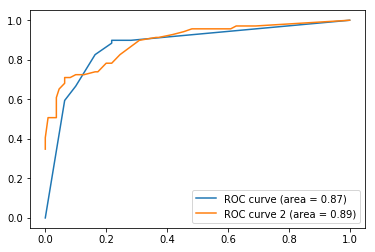

In [105]:
plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr2,tpr2, label='ROC curve 2 (area = %0.2f)' % roc_auc2)

plt.legend(loc="lower right")
plt.show()

In [106]:
roc_curve??

[]

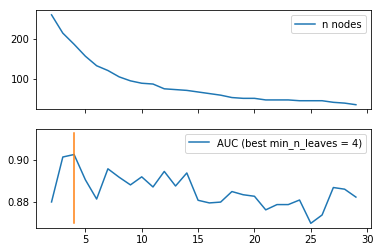

In [107]:
roc_auc_i = []
value_list = range(2,30)
n_nodes = []

# Fitting Graph  -- with ROC AUC as performance measure
for i in value_list:
    clf_i = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                  min_samples_split=2, min_samples_leaf=  i  )
    clf_i = clf_i.fit(train_x, train_y)
    y_score_i = clf_i.predict_proba(test_x)
    fpr_i, tpr_i, _ =  roc_curve(test_y, y_score_i[:,1])
    roc_auc_i.append(auc(fpr_i, tpr_i))
    n_nodes.append(clf_i.tree_.node_count)

best_value = value_list[np.argmax(roc_auc_i)]
best_roc = np.max(roc_auc_i)
worst_roc = np.min(roc_auc_i)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(value_list, n_nodes, label="n nodes")
axarr[0].legend(loc="upper right")
axarr[1].plot(value_list, roc_auc_i, label="AUC (best min_n_leaves = %s)" % best_value)
axarr[1].plot([best_value, best_value], [worst_roc, best_roc + 0.01])
axarr[1].legend(loc="upper right")
plt.plot()

In [108]:
range(int(train_y.shape[0]/20),train_y.shape[0],int(train_y.shape[0]/20))

range(35, 712, 35)

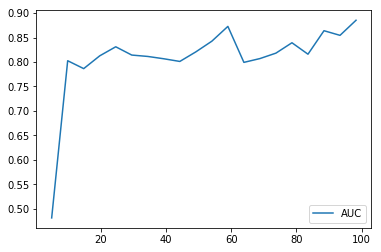

In [109]:
roc_auc_i = []
value_list = range(int(train_y.shape[0]/20),train_y.shape[0],int(train_y.shape[0]/20))

# Learning Curve  -- with ROC AUC as performance measure
#    for predefined L.C. see: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve
for i in value_list:
    train_x_sample = train_x[0:i]
    train_y_sample = train_y[0:i]
    clf_i = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                  min_samples_split=2, min_samples_leaf= 3  )
    clf_i = clf_i.fit(train_x_sample, train_y_sample)
    y_score_i = clf_i.predict_proba(test_x)
    fpr_i, tpr_i, _ =  roc_curve(test_y, y_score_i[:,1])
    roc_auc_i.append(auc(fpr_i, tpr_i))

plt.plot(np.array(value_list)*100/train_y.shape[0], roc_auc_i, label="AUC")
plt.legend(loc="lower right")
_ = plt.plot()

In [110]:
# Bagging

from sklearn.ensemble import BaggingClassifier

clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                  min_samples_split=2, min_samples_leaf=3)
# max_sample = 100% + Bootstrap ==> ~62% of original dataset used as sample
bag = BaggingClassifier(clf, n_estimators=20, max_samples=1.0, bootstrap=True)
bag = bag.fit(train_x, train_y)

y_score = bag.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
print("Bagging:", auc(fpr, tpr))

clf = clf.fit(train_x, train_y)
y_score = clf.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
print("Single DT:", auc(fpr, tpr))

Bagging: 0.897826086957
Single DT: 0.906785243742


In [111]:
BaggingClassifier??

(array([  1.,   7.,   4.,  12.,  21.,  17.,  17.,  12.,   6.,   3.]),
 array([ 0.88695652,  0.89023057,  0.89350461,  0.89677866,  0.9000527 ,
         0.90332675,  0.90660079,  0.90987484,  0.91314888,  0.91642292,
         0.91969697]),
 <a list of 10 Patch objects>)

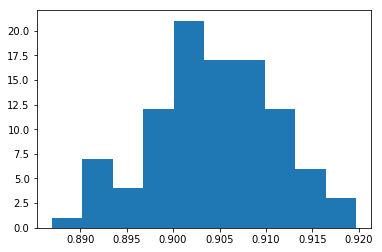

In [116]:
# Bagging / 2

from sklearn.ensemble import BaggingClassifier

results = []
for nnn in range(100):
    clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                      min_samples_split=2, min_samples_leaf=3)
    # max_sample = 100% + Bootstrap ==> ~62% of original dataset used as sample
    bag = BaggingClassifier(clf, n_estimators=20, max_samples=1.0, bootstrap=True)
    bag = bag.fit(train_x, train_y)

    y_score = bag.predict_proba(test_x)
    fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
#     print(auc(fpr, tpr))
    results.append(auc(fpr, tpr))
plt.hist(results)

In [118]:
# Boosting with AdaBoost
from sklearn.ensemble import AdaBoostClassifier

clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                      min_samples_split=2, min_samples_leaf=20)
ada = AdaBoostClassifier(base_estimator=clf, n_estimators=100)
ada = ada.fit(train_x, train_y)

y_score = ada.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
print(auc(fpr, tpr))

0.888801054018


In [119]:
AdaBoostClassifier??